In [20]:
import os
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn import svm
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'Raw_debates')
RESULT_DIR = os.path.join(ROOT_DIR, 'candidate_lines')

candidates = {'CLINTON', 'SANDERS', 'TRUMP', 'RUBIO', 'CRUZ'}
cand_list = sorted(candidates)

stops = set(stopwords.words("english"))

%matplotlib inline

In [2]:
word_dic = {'action': 'act',
               'agreement': 'agree',
               'americans': 'american',
               'asked': 'ask',
               'asking': 'ask',
               'going': 'go',
               'states': 'state',
               'working': 'work',
               'millions': 'million',
               'bringing': 'bring',
               'businesses': 'business',
               'candidates': 'candidate',
               'children': 'child',
               'comes': 'come',
               'coming': 'come',
               'companies': 'company',
               'countries': 'country',
               'deals': 'deal',
               'economic': 'economy',
               'families': 'family',
               'fighting': 'fight',
               'gets': 'get',
               'getting': 'get',
               'goes': 'go',
               'got': 'get',
               'groups': 'group',
               'guns': 'gun',
               'happened': 'happen',
               'happening': 'happen',
               'helped': 'help',
               'issues': 'issue',
               'knows': 'know',
               'laws': 'law',
               'lives': 'live',
               'living': 'live',
               'making': 'make',
               'needs': 'need',
               'passed': 'pass',
               'problems': 'problem',
               'putting': 'put',
               'really': 'real',
               'republicans': 'republican',
               'running': 'run',
               'saying': 'say',
               'said': 'say',
               'seeing': 'see',
               'seen': 'see',
               'started': 'start',
               'supported': 'support',
               'taking': 'take',
               'talked': 'talk',
               'talking': 'talk',
               'terrorists': 'terrorist',
               'terrorism': 'terrorist',
               'things': 'thing',
               'trying': 'try',
               'used': 'use',
               'using': 'use',
               'voted': 'vote',
               'wages': 'wage',
               'wanted': 'want',
               'wants': 'want',
               'building': 'build',
               'called': 'call',
               'came': 'come',
               'communities': 'community',
               'costs': 'cost',
               'deffence': 'deffend',
               'difference': 'different',
               'drugs': 'drug',
               'gave': 'give',
               'given': 'give',
               'gone': 'go',
               'higher': 'high',
               'highest': 'high',
               'interests': 'interest',
               'jobs': 'job',
               'longer': 'long',
               'looked': 'look',
               'looking': 'look',
               'lost': 'lose',
               'made': 'make',
               'means': 'mean',
               'paying': 'pay',
               'planned': 'plan',
               'programs': 'program',
               'raising': 'raise',
               'reasons': 'reason',
               'ringing': 'ring',
               'says': 'say',
               'saw': 'see',
               'wealthy': 'wealth',
               'worked': 'work',
               'allowed': 'allow',
               'built': 'build',
               'years': 'year'}

In [3]:
block_dic = {}

def get_raw_text(cand_name):
    file_name = '{0}.txt'.format(cand_name)
    file_path = os.path.join(RESULT_DIR, file_name)
    with open(file_path, 'rb') as f:
        return f.read()

def raw_to_blocks(cand_name, raw_text, delimiter='\r\n\r\n', min_len=200):
    # Delete candidate's name
    names_removed = raw_text.replace(cand_name + ':', '')
    
    # Split the text into paragraphs
    splitted = names_removed.split(delimiter)

    # Gather only long enough paragraphs
    rets = [paragraph for paragraph in splitted if len(paragraph) > min_len]
    return rets

# Replace words that are virtually same into one word. 
def hard_code_process(text):
    separate_word = ' {0} '
    text = separate_word.format(text)
    
    for key, value in word_dic.iteritems():
        key = separate_word.format(key)
        value = separate_word.format(value)
        text = text.replace(key, value)
    return text

def process_paragraph(paragraph):
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", paragraph) 
    
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    rets = ' '.join(meaningful_words)
    return hard_code_process(rets)

def get_processed_lines(cand_name, delimiter='\r\n\r\n', min_len=200):
    raw_text = get_raw_text(cand_name)
    blocks = raw_to_blocks(cand_name, raw_text, 
                           delimiter=delimiter, min_len=min_len)
    ret = map(process_paragraph, blocks)
    for k, v in zip(ret, blocks):
        block_dic[k] = v
    return ret

def get_vectorizer(cand_lines, max_features=1000):
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.  
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = max_features)
    
    concatenated = []
    for cand_name, lines in cand_lines.iteritems():
        concatenated += lines
    
    vectorizer.fit(concatenated)
    return vectorizer

In [4]:
# Split training data and test data
def test_train_split(cand_lines, test_ratio=0.25):
    cands = cand_lines.keys()
    test_data = dict.fromkeys(cands)
    train_data = dict.fromkeys(cands)
    for c in cands:
        lines = cand_lines[c]
        l = len(lines)
        test_len = int(l * test_ratio)
        test_indices = set(np.random.choice(l, test_len, replace=False))
        train_indices = set(range(l)) - test_indices
        test_data[c] = list(np.take(lines, list(test_indices)))
        train_data[c] = list(np.take(lines, list(train_indices)))
    return test_data, train_data

def normalize(data):
    rets = dict()
    for c in data:
        d = data[c].astype(float)
        _sum = d.sum(axis=1)
        _sum[_sum==0] = 1
        rets[c] = (d.T / _sum).T
    return rets

def pie_chart(vector, vocab):
    vocab = np.array(vocab)
    cond = vector > 0
    words = vocab[cond]
    sizes = vector[cond]
    plt.pie(sizes, labels=words)

In [5]:
# Examples
cand_lines = {c: get_processed_lines(c, min_len=400) for c in candidates}
vectorizer = get_vectorizer(cand_lines, 500)

vocab = vectorizer.get_feature_names()
clinton_train = vectorizer.transform(cand_lines['CLINTON']).toarray()

In [8]:
# Process the data

cand_lines = {c: get_processed_lines(c, min_len=200) for c in candidates}
raw_test_data, raw_train_data = test_train_split(cand_lines, 0.25)
train_data = dict.fromkeys(cand_list)
test_data = dict.fromkeys(cand_list)

vectorizer = get_vectorizer(raw_train_data, 500)
vocab = vectorizer.get_feature_names()

for c in train_data:
    train_data[c] = vectorizer.transform(raw_train_data[c]).toarray()
    test_data[c] = vectorizer.transform(raw_test_data[c]).toarray()

train_data = normalize(train_data)
test_data = normalize(test_data)

train_x, test_x = None, None
train_y, test_y = [], []

raw_train_x, raw_test_x = [], []

for c in train_data:
    i  = cand_list.index(c)
    if train_x is None:
        train_x = train_data[c]
    else:
        train_x = np.concatenate((train_x, train_data[c]))
    raw_train_x += raw_train_data[c]
    train_y += [i] * len(train_data[c])
    
for c in test_data:
    i  = cand_list.index(c)
    if test_x is None:
        test_x = test_data[c]
    else:
        test_x = np.concatenate((test_x, test_data[c]))
    raw_test_x += raw_test_data[c]
    test_y += [i] * len(test_data[c])
    
train_y = np.array(train_y)
test_y = np.array(test_y)

def to_actual_line(i):
    key = raw_test_x[i]
    return block_dic[key]

In [24]:
# Optimize C and gamma

_C = []
_gamma = []
_train = []
_test = []

for C in [1, 10, 100]:
    for gamma in [0.01, 0.1, 1, 10]:
        clf = svm.SVC(C=C, gamma=gamma)
        clf.fit(train_x, train_y)
        _C.append(C)
        _gamma.append(gamma)
        _train.append(clf.score(train_x, train_y))
        _test.append(clf.score(test_x, test_y))

In [25]:
# min_len = 200, num_words = 200

DataFrame({'C': _C, 'gamma': _gamma, 'train_score': _train, 'test_score': _test})

,C,gamma,test_score,train_score
0,1,0.01,0.211650,0.210560
1,1,0.10,0.211650,0.213780
2,1,1.00,0.561165,0.705731
3,1,10.00,0.590291,0.963941
4,10,0.01,0.213592,0.214424
5,10,0.10,0.561165,0.703155
6,10,1.00,0.615534,0.858983
7,10,10.00,0.611650,1.000000
8,100,0.01,0.559223,0.699936
9,100,0.10,0.596117,0.808113


In [9]:
# min_len = 200, num_words = 500

DataFrame({'C': _C, 'gamma': _gamma, 'train_score': _train, 'test_score': _test})

,C,gamma,test_score,train_score
0,1,0.01,0.211650,0.210560
1,1,0.10,0.211650,0.210560
2,1,1.00,0.634951,0.729556
3,1,10.00,0.732039,0.960721
4,10,0.01,0.211650,0.210560
5,10,0.10,0.633010,0.732775
6,10,1.00,0.710680,0.927238
7,10,10.00,0.718447,1.000000
8,100,0.01,0.629126,0.729556
9,100,0.10,0.695146,0.908564


In [22]:
# min_len = 200, num_words = 1000

DataFrame({'C': _C, 'gamma': _gamma, 'train_score': _train, 'test_score': _test})

,C,gamma,test_score,train_score
0,1,0.01,0.211650,0.210560
1,1,0.10,0.211650,0.210560
2,1,1.00,0.634951,0.730200
3,1,10.00,0.726214,0.958789
4,10,0.01,0.211650,0.210560
5,10,0.10,0.648544,0.743722
6,10,1.00,0.724272,0.942048
7,10,10.00,0.743689,1.000000
8,100,0.01,0.642718,0.739858
9,100,0.10,0.728155,0.933033


In [19]:
# min_len = 400, num_words = 500

DataFrame({'C': _C, 'gamma': _gamma, 'train_score': _train, 'test_score': _test})

,C,gamma,test_score,train_score
0,1,0.01,0.245614,0.240000
1,1,0.10,0.245614,0.240000
2,1,1.00,0.245614,0.240000
3,1,10.00,0.701754,0.971429
4,10,0.01,0.245614,0.240000
5,10,0.10,0.245614,0.240000
6,10,1.00,0.710526,0.974286
7,10,10.00,0.763158,1.000000
8,100,0.01,0.245614,0.240000
9,100,0.10,0.684211,0.962857


In [9]:
# Best model

clf = svm.SVC(C=10, gamma=10, probability=True)
clf.fit(train_x, train_y)
clf.score(test_x, test_y)

0.6912621359223301

In [10]:
# One word test1

clf.predict(np.eye(500))

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4,

In [65]:
# One word test2

x = clf.predict_proba(np.eye(500))
df = DataFrame(x, columns=cand_list)

df.describe()

,CLINTON,CRUZ,RUBIO,SANDERS,TRUMP
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.035903,0.233178,0.225803,0.047535,0.457581
std,0.001292,0.010233,0.032434,0.001802,0.020166
min,0.007286,0.022943,0.207872,0.007575,0.013114
25%,0.035929,0.233241,0.224167,0.047577,0.458361
50%,0.035957,0.233397,0.224329,0.047611,0.458560
75%,0.035986,0.233557,0.224478,0.047651,0.458818
max,0.037658,0.320959,0.949082,0.048920,0.465959


In [11]:
# Investigate predict_prob for test_data 1

x = clf.predict_proba(test_x)
df = DataFrame(x, columns=cand_list)

df.describe()

,CLINTON,CRUZ,RUBIO,SANDERS,TRUMP
count,515.000000,515.000000,515.000000,515.000000,515.000000
mean,0.212200,0.182173,0.221974,0.184472,0.199182
std,0.282613,0.275430,0.272654,0.257935,0.295508
min,0.000035,0.000017,0.000152,0.000134,0.000019
25%,0.017839,0.009719,0.018418,0.016478,0.005144
50%,0.078168,0.045020,0.097873,0.064199,0.038656
75%,0.286387,0.212810,0.326758,0.222471,0.295469
max,0.999363,0.992064,0.982096,0.990046,0.997180


<Container object of 500 artists>

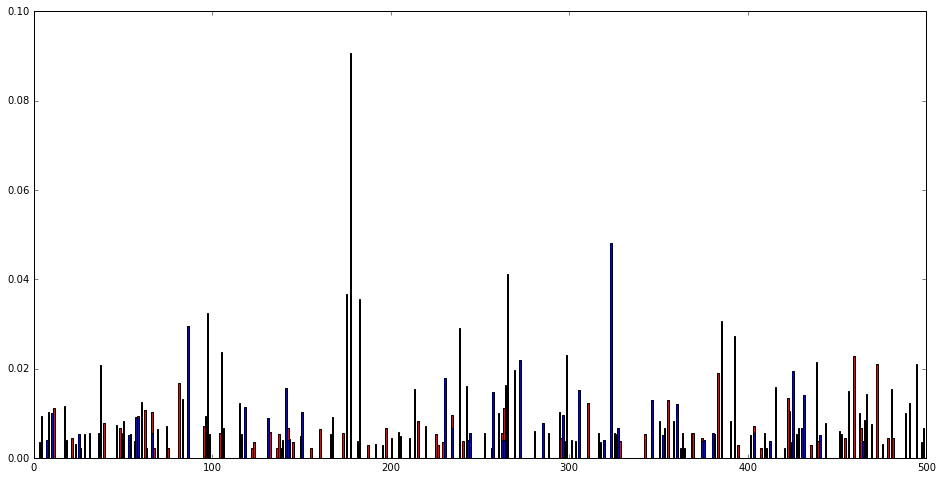

In [12]:
# Investigate predict_prob for test_data 2

index_df = DataFrame(columns=cand_list)

for c in cand_list:
    index_df[c] = df[c].sort_values().index[-10:]

x = np.zeros(500)
y = np.zeros(500)

for i in range(10):
    i1 = index_df.CLINTON[i]
    i2 = index_df.TRUMP[i]
    x += test_x[i1]
    y += test_x[i2]

plt.figure(figsize=(16, 8))
plt.ylim(0, 0.1)
plt.bar(range(500), x/10, color='red')
plt.bar(range(500), y/10, color='blue')

In [14]:
clf.predict_proba(x/10)

/Users/yhjung/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[  9.99332902e-01,   6.54542491e-07,   6.57274758e-06,
          6.46891159e-04,   1.29796677e-05]])

In [21]:
confusion_matrix(test_y, clf.predict(test_x))

array([[75,  5, 12, 10,  7],
       [ 4, 68, 16,  3,  7],
       [ 7, 12, 73,  2, 14],
       [16,  6,  9, 57, 10],
       [ 2,  3,  6,  8, 83]])

In [19]:
from sklearn.metrics import classification_report

print classification_report(test_y, clf.predict(test_x), target_names=cand_list)

             precision    recall  f1-score   support

    CLINTON       0.72      0.69      0.70       109
       CRUZ       0.72      0.69      0.71        98
      RUBIO       0.63      0.68      0.65       108
    SANDERS       0.71      0.58      0.64        98
      TRUMP       0.69      0.81      0.74       102

avg / total       0.69      0.69      0.69       515



In [16]:
to_actual_line(i1)

" So I'm with both Senator Sanders and Governor O'Malley in putting a lot of attention onto the banks. And the plan that I have put forward would actually empower regulators to break up big banks if we thought they posed a risk. But I want to make sure we're going to cover everybody, not what caused the problem last time, but what could cause it next time."

In [17]:
to_actual_line(i2)

" Let me just tell you. Jeb goes around saying, just like the biggest business leaders in this country, I've used the laws of the land to chapter \x97 I bought a company, I threw it immediately into a chapter, I made a great deal. I uses the laws to my benefit, because I run a company."